## Project 1


Part a) : Ordinary Least Square (OLS) on the Franke function

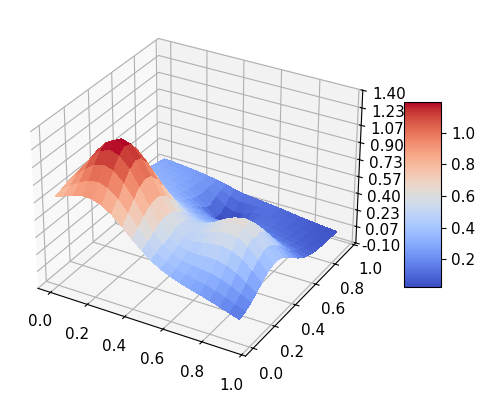

In [88]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)


# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

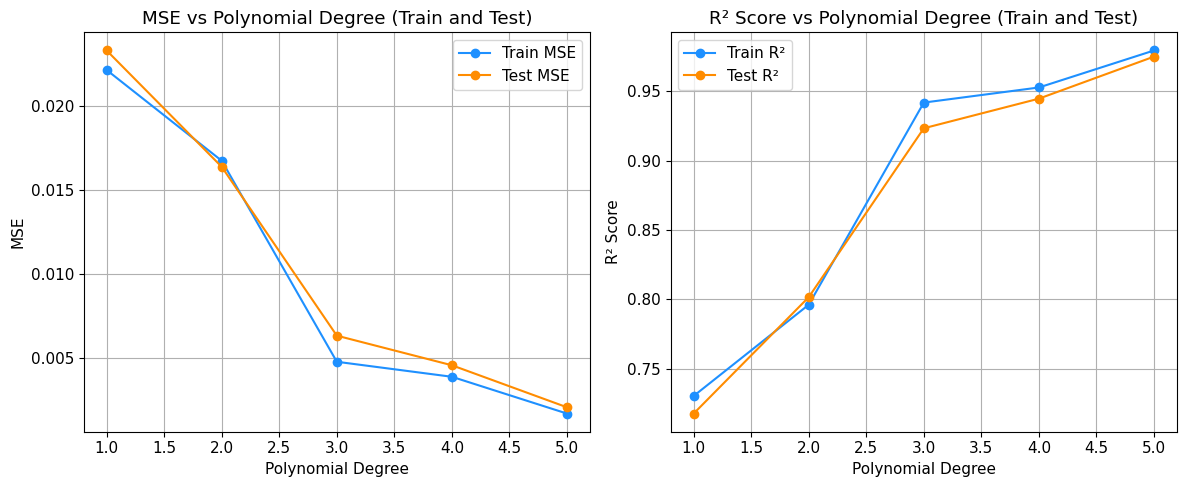

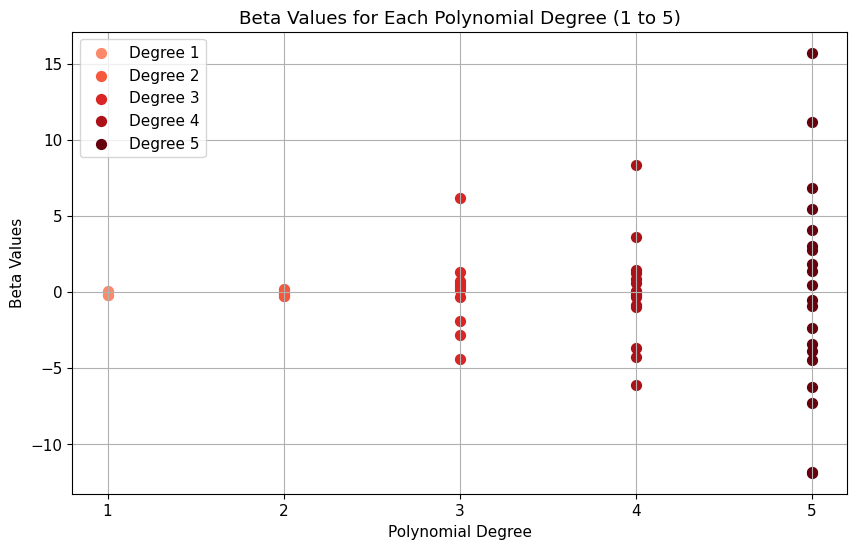

In [89]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Franke Function definition
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2) ** 2) - 0.25 * ((9 * y - 2) ** 2))
    term2 = 0.75 * np.exp(-((9 * x + 1) ** 2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7) ** 2 / 4.0 - 0.25 * ((9 * y - 3) ** 2))
    term4 = -0.2 * np.exp(-(9 * x - 4) ** 2 - (9 * y - 7) ** 2)
    return term1 + term2 + term3 + term4

# Create design matrix with polynomial features
def create_X(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
    
    N = len(x)
    l = int((n + 1) * (n + 2) / 2)  # Number of elements in beta
    X = np.ones((N, l))
    
    for i in range(1, n + 1):
        q = int((i) * (i + 1) / 2)
        for k in range(i + 1):
            X[:, q + k] = (x ** (i - k)) * (y ** k)
    
    return X

np.random.seed(1042)

# Generate data
n = 5
N = 1000
x = np.random.uniform(0, 1, N)
y = np.random.uniform(0, 1, N)
z = FrankeFunction(x, y)

# Create polynomial design matrix for degree 5
X = create_X(x, y, n=n)
X = X[:, 1:]  # Remove the intercept column for now

# Split into training and test data
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Center the z values
z_train_mean = np.mean(z_train)
z_train_scaled = z_train - z_train_mean
z_test_scaled = z_test - z_train_mean

# OLS with different polynomial degrees
degree = 5
MSE_train_values = []
MSE_test_values = []
R2_train_values = []
R2_test_values = []
beta_values = []

for i in range(1, degree + 1):
    c = int((i + 2) * (i + 1) / 2)
    X_tilde_train = X_train_scaled[:, :c]
    X_tilde_test = X_test_scaled[:, :c]
    
    beta = np.linalg.pinv(X_tilde_train.T @ X_tilde_train) @ X_tilde_train.T @ z_train_scaled
    beta_values.append(beta)
    
    y_train_pred = X_tilde_train @ beta + z_train_mean
    y_test_pred = X_tilde_test @ beta + z_train_mean
    
    MSE_train_values.append(mean_squared_error(z_train, y_train_pred))
    MSE_test_values.append(mean_squared_error(z_test, y_test_pred))
    R2_train_values.append(r2_score(z_train, y_train_pred))
    R2_test_values.append(r2_score(z_test, y_test_pred))

degrees = np.arange(1, degree + 1)

plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(degrees, MSE_train_values, marker='o', label='Train MSE', color='dodgerblue')
plt.plot(degrees, MSE_test_values, marker='o', label='Test MSE', color='darkorange')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE vs Polynomial Degree (Train and Test)')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(degrees, R2_train_values, marker='o', label='Train R²', color='dodgerblue')
plt.plot(degrees, R2_test_values, marker='o', label='Test R²', color='darkorange')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('R² Score vs Polynomial Degree (Train and Test)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))

reds = plt.cm.Reds(np.linspace(0.4, 1, 5)) 

for i, beta in enumerate(beta_values[:5]):
    plt.scatter([i + 1] * len(beta), beta, marker='o', color=reds[i], label=f'Degree {i+1}', s=50)

plt.xticks(np.arange(1, 6))
plt.xlabel('Polynomial Degree')
plt.ylabel('Beta Values')
plt.title('Beta Values for Each Polynomial Degree (1 to 5)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


Part b): Adding Ridge regression for the Franke function

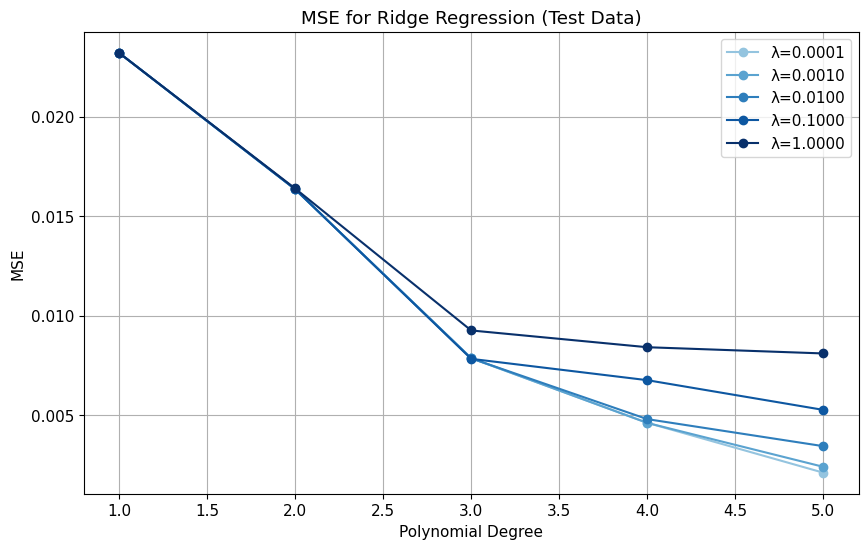

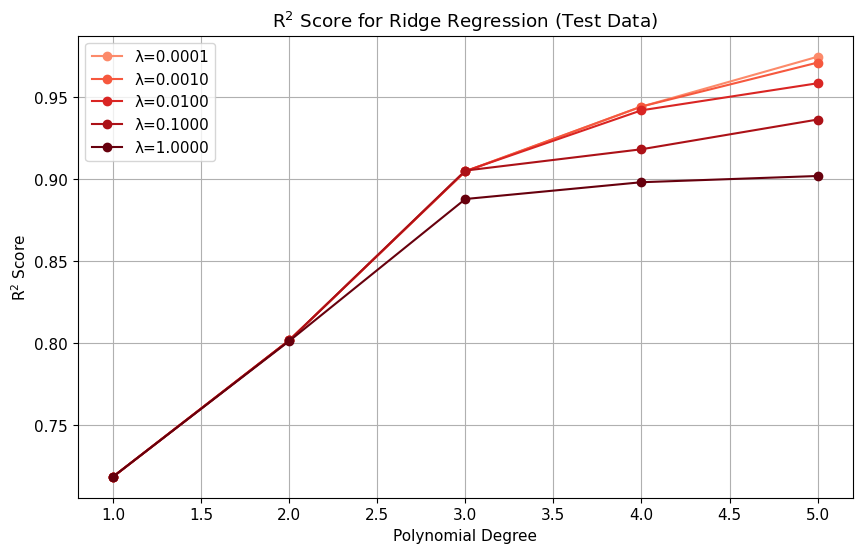

In [103]:
degrees = np.arange(1, 6)
lambdas = np.logspace(-4, 0, 5) 

MSE_Ridge_train = np.zeros((len(degrees), len(lambdas)))
MSE_Ridge_test = np.zeros((len(degrees), len(lambdas)))
R2_Ridge_train = np.zeros((len(degrees), len(lambdas)))
R2_Ridge_test = np.zeros((len(degrees), len(lambdas)))

for i, deg in enumerate(degrees):
    X = create_X(x, y, n=deg)
    X = X[:, 1:]  # Remove the intercept for now

    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Center
    z_train_mean = np.mean(z_train)
    z_train_scaled = z_train - z_train_mean
    z_test_scaled = z_test - z_train_mean


    p = X_train_scaled.shape[1]
    I = np.eye(p)

    for j, lmb in enumerate(lambdas):
        # Ridge regression
        Ridgebeta = np.linalg.inv(X_train_scaled.T @ X_train_scaled + lmb * I) @ X_train_scaled.T @ z_train_scaled
        
        y_train_pred = X_train_scaled @ Ridgebeta + z_train_mean
        y_test_pred = X_test_scaled @ Ridgebeta + z_train_mean

        MSE_Ridge_train[i, j] = mean_squared_error(z_train, y_train_pred)
        MSE_Ridge_test[i, j] = mean_squared_error(z_test, y_test_pred)
        R2_Ridge_train[i, j] = r2_score(z_train, y_train_pred)
        R2_Ridge_test[i, j] = r2_score(z_test, y_test_pred)

#pretty colors
mse_colors = plt.cm.Blues(np.linspace(0.4, 1, len(lambdas)))
r2_colors = plt.cm.Reds(np.linspace(0.4, 1, len(lambdas)))

plt.rcParams.update({'font.size': 11})


plt.figure(figsize=(10, 6))
for j, lmb in enumerate(lambdas):
    plt.plot(degrees, MSE_Ridge_test[:, j], marker='o', label=f'λ={lmb:.4f}', color=mse_colors[j])
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE for Ridge Regression (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for j, lmb in enumerate(lambdas):
    plt.plot(degrees, R2_Ridge_test[:, j], marker='o', label=f'λ={lmb:.4f}', color=r2_colors[j])
plt.xlabel('Polynomial Degree')
plt.ylabel('R$^2$ Score')
plt.title('R$^2$ Score for Ridge Regression (Test Data)')
plt.legend()
plt.grid(True)
plt.show()


Part c): Adding Lasso for the Franke function

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.815e-01, tolerance: 6.562e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.179e-01, tolerance: 6.562e-03
  model = cd_fast.enet_coordinate_descent(


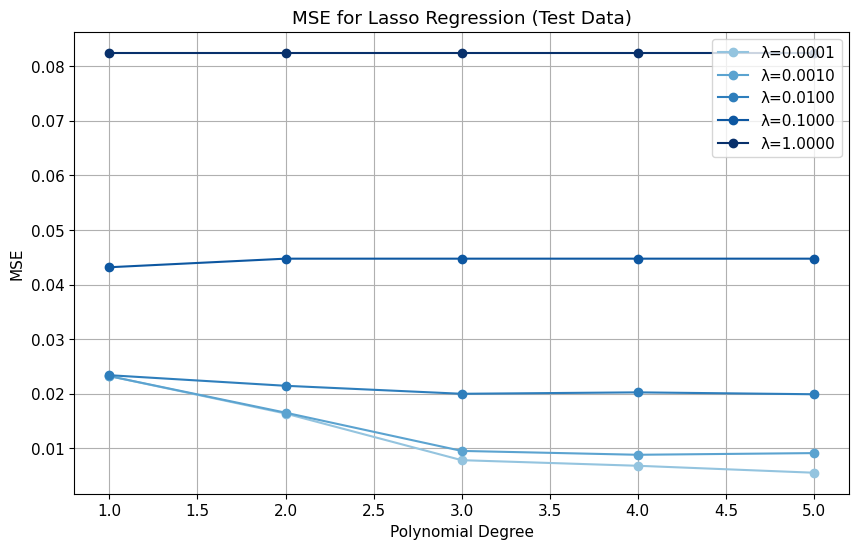

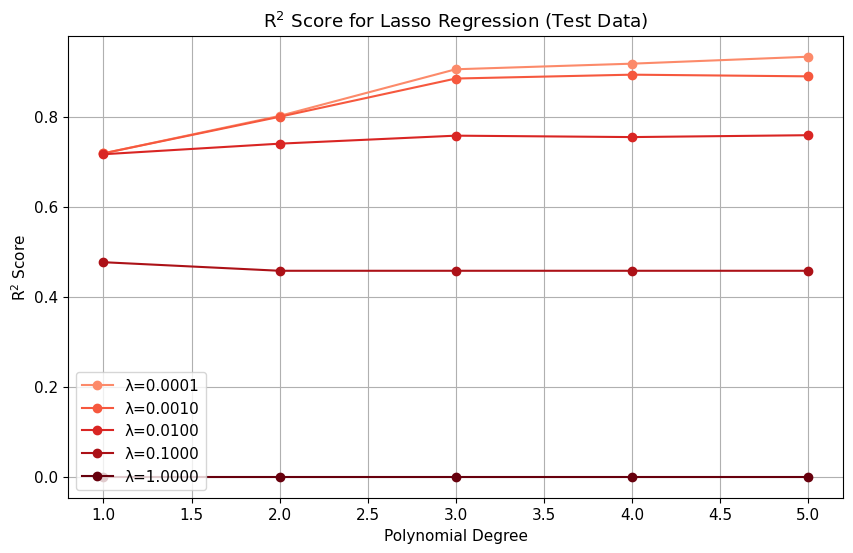

In [104]:
from sklearn.linear_model import Lasso 

MSE_Lasso_train = np.zeros((len(degrees), len(lambdas)))
MSE_Lasso_test = np.zeros((len(degrees), len(lambdas)))
R2_Lasso_train = np.zeros((len(degrees), len(lambdas)))
R2_Lasso_test = np.zeros((len(degrees), len(lambdas)))

for i, deg in enumerate(degrees):
    X = create_X(x, y, n=deg)
    X = X[:, 1:]  # Remove the intercept

    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)
  
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    z_train_mean = np.mean(z_train)
    z_train_scaled = z_train - z_train_mean
    z_test_scaled = z_test - z_train_mean


    for j, lmb in enumerate(lambdas):

        lasso = Lasso(alpha=lmb, max_iter=10000) 
        lasso.fit(X_train_scaled, z_train_scaled)

        y_train_pred = lasso.predict(X_train_scaled) + z_train_mean
        y_test_pred = lasso.predict(X_test_scaled) + z_train_mean

        MSE_Lasso_train[i, j] = mean_squared_error(z_train, y_train_pred)
        MSE_Lasso_test[i, j] = mean_squared_error(z_test, y_test_pred)
        R2_Lasso_train[i, j] = r2_score(z_train, y_train_pred)
        R2_Lasso_test[i, j] = r2_score(z_test, y_test_pred)


mse_colors = plt.cm.Blues(np.linspace(0.4, 1, len(lambdas)))
r2_colors = plt.cm.Reds(np.linspace(0.4, 1, len(lambdas)))
plt.rcParams.update({'font.size': 11})

plt.figure(figsize=(10, 6))
for j, lmb in enumerate(lambdas):
    plt.plot(degrees, MSE_Lasso_test[:, j], marker='o', label=f'λ={lmb:.4f}', color=mse_colors[j])
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE for Lasso Regression (Test Data)')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
for j, lmb in enumerate(lambdas):
    plt.plot(degrees, R2_Lasso_test[:, j], marker='o', label=f'λ={lmb:.4f}', color=r2_colors[j])
plt.xlabel('Polynomial Degree')
plt.ylabel('R$^2$ Score')
plt.title('R$^2$ Score for Lasso Regression (Test Data)')
plt.legend()
plt.grid(True)
plt.show()


Plottet OLS, Rigde and Lasso together:

In [92]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

def MSE(y_data, y_model):
    n = np.size(y_model)
    return np.sum((y_data - y_model)**2) / n


def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model)**2) / np.sum((y_data - np.mean(y_data))**2)



N = 1000
x = np.random.uniform(0, 1, N)
y = np.random.uniform(0, 1, N)
z = FrankeFunction(x, y) + 0.1 * np.random.randn(N) 

Maxpolydegree = 5
poly = PolynomialFeatures(degree=Maxpolydegree)
X = poly.fit_transform(np.c_[x, y])  

# Split the data into training and testing sets
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)


nlambdas = 5
lambdas = np.logspace(-4, 0, nlambdas)

model = Ridge()
gridsearch = GridSearchCV(estimator=model, param_grid={'alpha': lambdas}, scoring='neg_mean_squared_error', cv=5)
gridsearch.fit(X_train, z_train)

model2 = Lasso()
gridsearch2 = GridSearchCV(estimator=model2, param_grid={'alpha': lambdas}, scoring='neg_mean_squared_error', cv=5)
gridsearch2.fit(X_train,z_train)


ypredictRidge = gridsearch.predict(X_test)
ypredictLasso = gridsearch2.predict(X_test)



print(f"Best estimated lambda-value Ridge: {gridsearch.best_estimator_.alpha}")
print(f"MSE score: {MSE(z_test, ypredictRidge):.5f}")
print(f"R2 score: {R2(z_test, ypredictRidge):.5f}")
print(f"Best estimated lambda-value Lasso: {gridsearch2.best_estimator_.alpha}")

print(f"MSE score: {MSE(z_test, ypredictLasso):.5f}")
print(f"R2 score: {R2(z_test, ypredictLasso):.5f}")

Best estimated lambda-value Ridge: 0.0001
MSE score: 0.01366
R2 score: 0.86480
Best estimated lambda-value Lasso: 0.0001
MSE score: 0.02015
R2 score: 0.80053


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.256e-01, tolerance: 6.079e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.018e-01, tolerance: 5.937e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

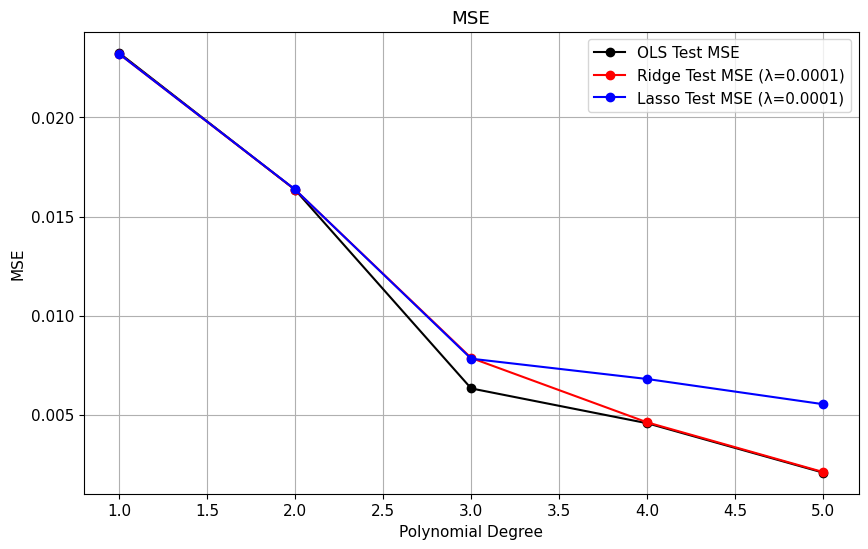

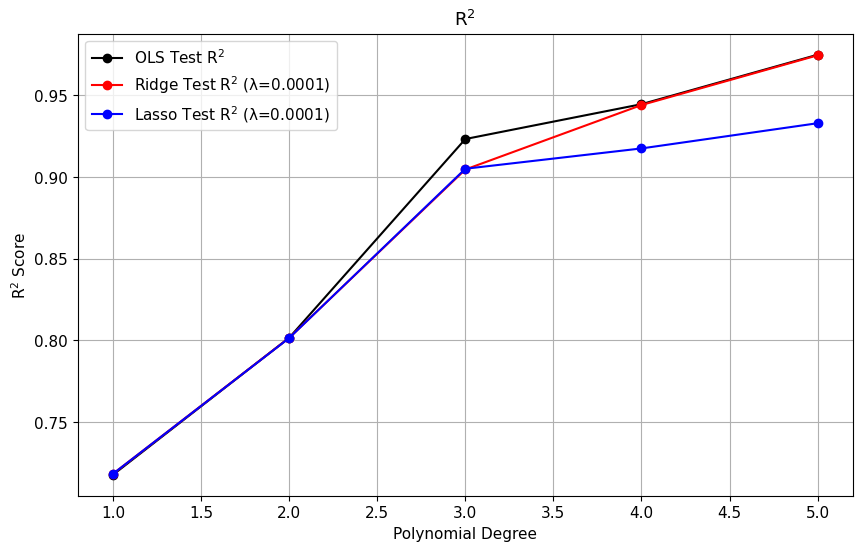

In [93]:
# best lambda value
lambda_value = 0.0001

best_MSE_Ridge_test = MSE_Ridge_test[:, 0] 
best_MSE_Lasso_test = MSE_Lasso_test[:, 0]

best_R2_Ridge_test = R2_Ridge_test[:, 0]
best_R2_Lasso_test = R2_Lasso_test[:, 0]

plt.rcParams.update({'font.size': 11})

plt.figure(figsize=(10, 6))
plt.plot(degrees, MSE_test_values, marker='o', label='OLS Test MSE', color='black')
plt.plot(degrees, best_MSE_Ridge_test, marker='o', label='Ridge Test MSE (λ=0.0001)', color='red')
plt.plot(degrees, best_MSE_Lasso_test, marker='o', label='Lasso Test MSE (λ=0.0001)', color='blue')

plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE')
plt.legend()
plt.grid(True)
plt.show()  # Show the MSE plot once

plt.figure(figsize=(10, 6))
plt.plot(degrees, R2_test_values, marker='o', label='OLS Test R$^2$', color='black')
plt.plot(degrees, best_R2_Ridge_test, marker='o', label='Ridge Test R$^2$ (λ=0.0001)', color='red')
plt.plot(degrees, best_R2_Lasso_test, marker='o', label='Lasso Test R$^2$ (λ=0.0001)', color='blue')

plt.xlabel('Polynomial Degree')
plt.ylabel('R$^2$ Score')
plt.title('R$^2$')
plt.legend()
plt.grid(True)
plt.show()


Part e): Bias-variance trade-off and resampling techniques

Degree 1: Error = 0.0316, Bias ^2 = 0.0298, Variance = 0.0018
Degree 2: Error = 0.0306, Bias ^2 = 0.0256, Variance = 0.0049
Degree 3: Error = 0.0383, Bias ^2 = 0.0301, Variance = 0.0082
Degree 4: Error = 0.0424, Bias ^2 = 0.0241, Variance = 0.0182
Degree 5: Error = 0.0874, Bias ^2 = 0.0153, Variance = 0.0720


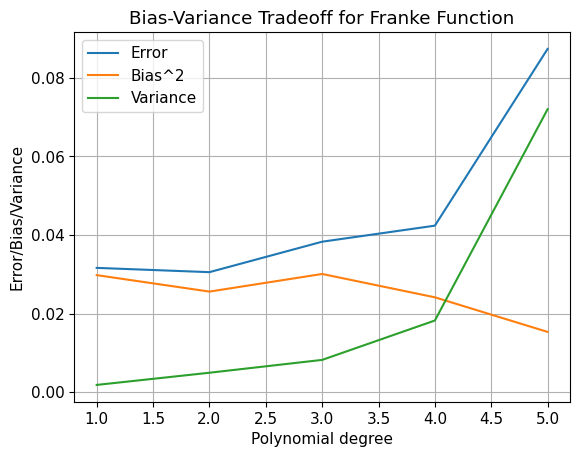

In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2) ** 2) - 0.25 * ((9 * y - 2) ** 2))
    term2 = 0.75 * np.exp(-((9 * x + 1) ** 2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7) ** 2 / 4.0 - 0.25 * ((9 * y - 3) ** 2))
    term4 = -0.2 * np.exp(-(9 * x - 4) ** 2 - (9 * y - 7) ** 2)
    return term1 + term2 + term3 + term4

np.random.seed(1042)

n = 100
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y) + 0.1 * np.random.normal(0, 1, x.shape)

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
X = np.hstack((x, y)) 

n_boostraps = 100
maxdegree = 5

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.arange(1, maxdegree + 1)

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

for degree in range(1, maxdegree + 1):
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))
    z_pred = np.empty((z_test.shape[0], n_boostraps)) 
    
    for i in range(n_boostraps):
        X_, z_ = resample(X_train, z_train)
        z_pred[:, i] = model.fit(X_, z_).predict(X_test).ravel()

    z_test = z_test.reshape(-1, 1)

    error[degree-1] = np.mean(np.mean((z_test - z_pred) ** 2, axis=1))
    bias[degree-1] = np.mean((z_test - np.mean(z_pred, axis=1, keepdims=True)) ** 2)
    variance[degree-1] = np.mean(np.var(z_pred, axis=1))

    print(f'Degree {degree}: Error = {error[degree-1]:.4f}, Bias ^2 = {bias[degree-1]:.4f}, Variance = {variance[degree-1]:.4f}')

plt.rcParams.update({'font.size': 11})
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='Bias^2')
plt.plot(polydegree, variance, label='Variance')
plt.xlabel('Polynomial degree')
plt.ylabel('Error/Bias/Variance')
plt.legend()
plt.title('Bias-Variance Tradeoff for Franke Function')
plt.grid(True)
plt.show()


Part f): Cross-validation as resampling techniques, adding more complexity

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.675e+00, tolerance: 5.828e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e+00, tolerance: 5.701e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

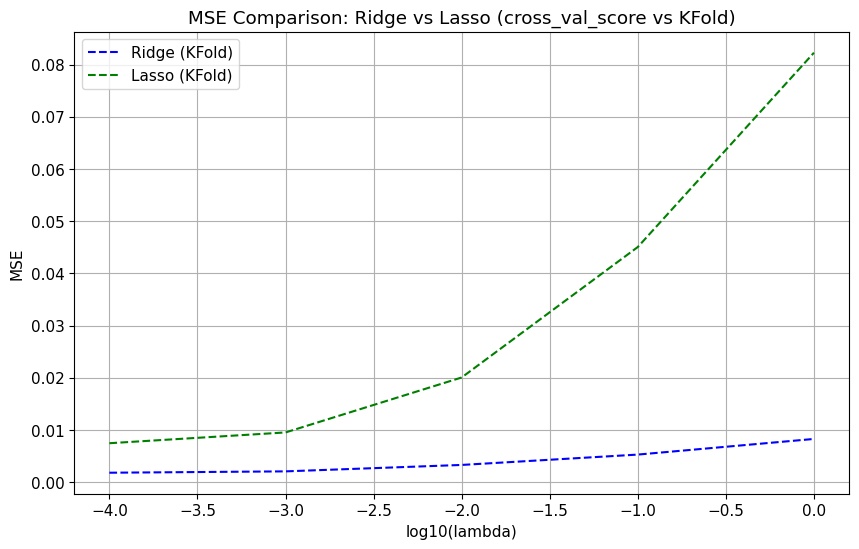

In [95]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Ridge, Lasso

# Franke Function definition
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2) ** 2) - 0.25 * ((9 * y - 2) ** 2))
    term2 = 0.75 * np.exp(-((9 * x + 1) ** 2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7) ** 2 / 4.0 - 0.25 * ((9 * y - 3) ** 2))
    term4 = -0.2 * np.exp(-(9 * x - 4) ** 2 - (9 * y - 7) ** 2)
    return term1 + term2 + term3 + term4

# Create design matrix with polynomial features
def create_X(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
    
    N = len(x)
    l = int((n + 1) * (n + 2) / 2)  # Number of elements in beta
    X = np.ones((N, l))
    
    for i in range(1, n + 1):
        q = int((i) * (i + 1) / 2)
        for k in range(i + 1):
            X[:, q + k] = (x ** (i - k)) * (y ** k)
    
    return X

np.random.seed(1042)

# Generate data
n = 5  # Polynomial degree
N = 1000
x = np.random.uniform(0, 1, N)
y = np.random.uniform(0, 1, N)
z = FrankeFunction(x, y)

X = create_X(x, y, n=n)
X = X[:, 1:]  # Remove the intercept column

# Split into training and test data
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Center the target (z) values
z_train_mean = np.mean(z_train)
z_train_scaled = z_train - z_train_mean
z_test_scaled = z_test - z_train_mean

nlambdas = 5
lambdas = np.logspace(-4, 0, nlambdas)

k = 8
kfold = KFold(n_splits=k)


scores_KFold_ridge = np.zeros((nlambdas, k))
scores_KFold_lasso = np.zeros((nlambdas, k))

i = 0
for lmb in lambdas:
    ridge = Ridge(alpha=lmb)
    lasso = Lasso(alpha=lmb)
    j = 0
    for train_inds, test_inds in kfold.split(X_train_scaled):
        Xtrain = X_train_scaled[train_inds]
        ztrain = z_train_scaled[train_inds]

        Xtest = X_train_scaled[test_inds]
        ztest = z_train_scaled[test_inds]

        # Ridge regression
        ridge.fit(Xtrain, ztrain)
        zpred_ridge = ridge.predict(Xtest)
        scores_KFold_ridge[i, j] = np.mean((zpred_ridge - ztest) ** 2)

        # Lasso regression
        lasso.fit(Xtrain, ztrain)
        zpred_lasso = lasso.predict(Xtest)
        scores_KFold_lasso[i, j] = np.mean((zpred_lasso - ztest) ** 2)

        j += 1
    i += 1


estimated_mse_KFold_ridge = np.mean(scores_KFold_ridge, axis=1)
estimated_mse_KFold_lasso = np.mean(scores_KFold_lasso, axis=1)

plt.rcParams.update({'font.size': 11})

plt.figure(figsize=(10, 6))
plt.plot(np.log10(lambdas), estimated_mse_KFold_ridge, 'r--', label='Ridge (KFold)', color='blue', linestyle='--')
plt.plot(np.log10(lambdas), estimated_mse_KFold_lasso, 'r--', label='Lasso (KFold)', color='green', linestyle='--')

plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE Comparison: Ridge vs Lasso (cross_val_score vs KFold)')
plt.grid(True)
plt.show()
